# Tutorial on Regularization and Crossvalidation

This tutorial is based on https://github.com/tyarkoni/PPS2016

by christian.pfeiffer@uzh.ch

## Load and examine data

The dataset we'll use is concerned with predicting the severity of diabetes. The dataset lives in the `lars` package:

In [1]:
if(!require("lars")){
  install.packages("lars")
  library("lars")
}
data("diabetes")

Loading required package: lars

Loaded lars 1.2




Let's do a little preliminary examination of the data. There are 442 observations, and we have 10 predictors to use for prediction, which we'll store in a matrix called `X`. They look like this:

[1] 442

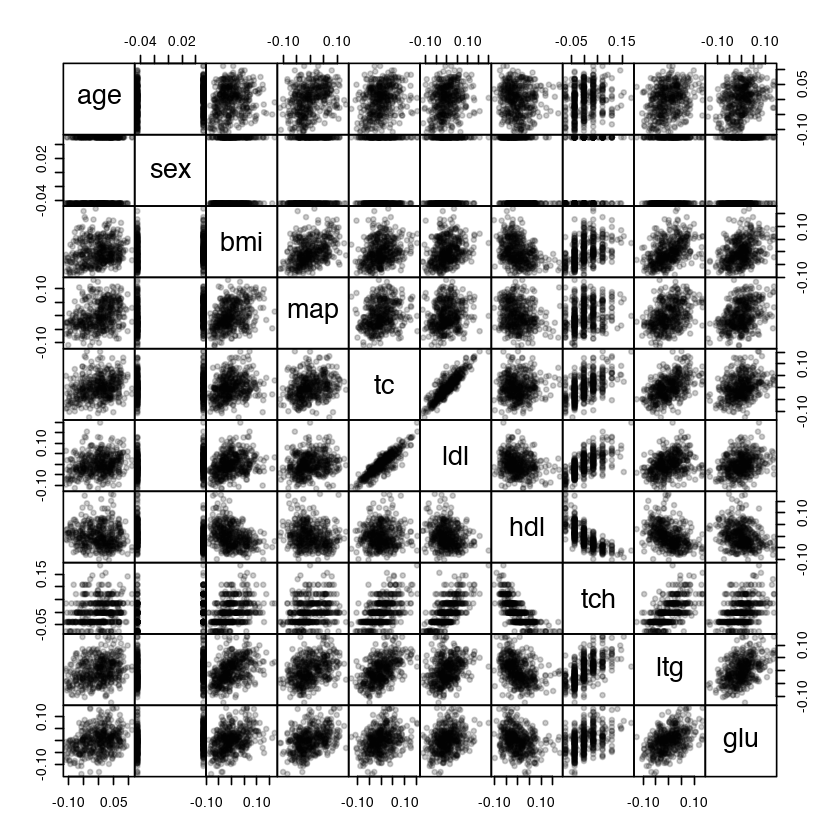

In [2]:
X <- diabetes$x
(N <- nrow(X))
pairs(X, pch=20, gap=0, col=rgb(0,0,0,.2))

Our response variable, which we'll store as a vector `y`, is some medical indicator of the severity of diabetes. It's a continuous variable and its distribution looks like this:

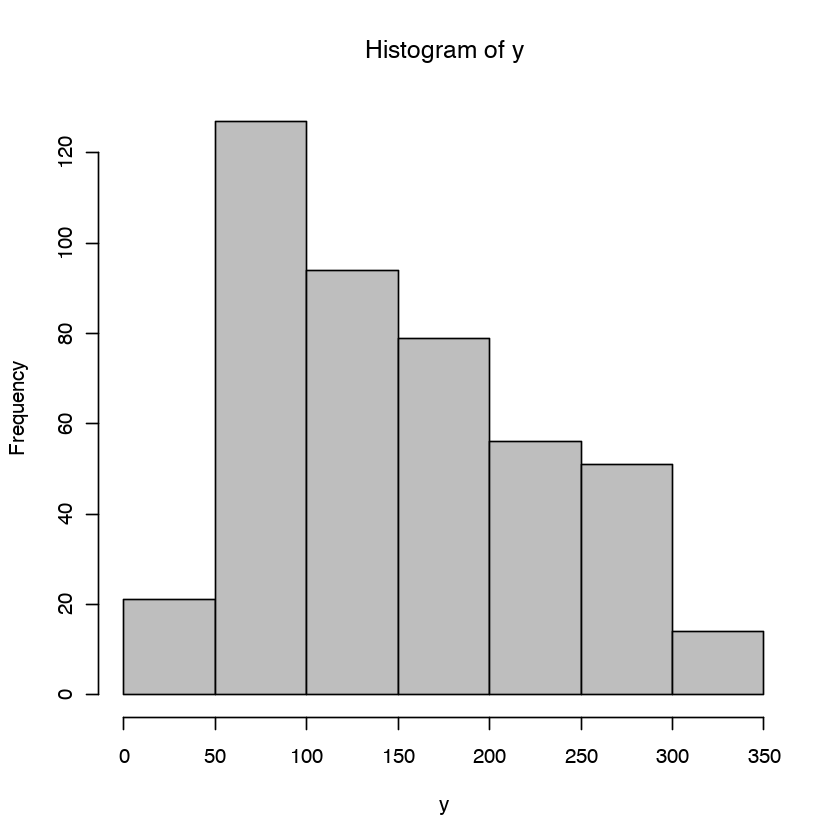

In [3]:
y <- diabetes$y
hist(y, col="gray")

## Fit ordinary multiple regression model

To start off, let's see what it looks like if we just throw these 10 predictors into a multiple regression model predicting `y`:

In [4]:
reg <- lm(y ~ X)
summary(reg)


Call:
lm(formula = y ~ X)

Residuals:
     Min       1Q   Median       3Q      Max 
-155.829  -38.534   -0.227   37.806  151.355 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  152.133      2.576  59.061  < 2e-16 ***
Xage         -10.012     59.749  -0.168 0.867000    
Xsex        -239.819     61.222  -3.917 0.000104 ***
Xbmi         519.840     66.534   7.813 4.30e-14 ***
Xmap         324.390     65.422   4.958 1.02e-06 ***
Xtc         -792.184    416.684  -1.901 0.057947 .  
Xldl         476.746    339.035   1.406 0.160389    
Xhdl         101.045    212.533   0.475 0.634721    
Xtch         177.064    161.476   1.097 0.273456    
Xltg         751.279    171.902   4.370 1.56e-05 ***
Xglu          67.625     65.984   1.025 0.305998    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.15 on 431 degrees of freedom
Multiple R-squared:  0.5177,	Adjusted R-squared:  0.5066 
F-statistic: 46.27 on 10 and 431 DF

The Root Mean Squared Error (RMSE) -- which the `summary()` function calls the "Residual standard error" -- is about 54. In other words, the model's predicted `y` values tended to be within about 54 units of the actual `y` values. Based on the distribution of `y` that we saw above, that seems pretty good!

However, as we just learned in the main text, this is likely an overestimate of this model's out-of-sample performance on future datasets. To get a good estimate of the test/prediction error, we can use **cross-validation**.

## 10-fold cross-validation (CV) by hand

Let's estimate the test/prediction error by 10-fold cross-validation, which we'll implement by hand first for instructional purposes.

First we shuffle the rows of the dataset, just in case they weren't put in the dataset in random order. We're going to partition the dataset into "folds" by selecting the first $N/10$ rows for Fold #1, the next $N/10$ rows for Fold #2, and so on, so we want to make sure the folds don't systematically differ based on their original position in the dataset.

In [5]:
set.seed(12345) # the same combination i have on my luggage!
new_indices <- sample(nrow(X))
y <- y[new_indices]
X <- X[new_indices,]

Now lets take all the indices -- that is, the numbers corresponding to each row of the dataset (1 to 442) -- and split them into 10 groups of roughly equal size.

In [6]:
breaks <- round(quantile(seq(N), probs=seq(0, 1, .1)))
groups <- cut(seq(N), breaks=breaks, include.lowest=TRUE)
indices <- split(seq(N), groups)
str(indices)

List of 10
 $ [1,45]   : int [1:45] 1 2 3 4 5 6 7 8 9 10 ...
 $ (45,89]  : int [1:44] 46 47 48 49 50 51 52 53 54 55 ...
 $ (89,133] : int [1:44] 90 91 92 93 94 95 96 97 98 99 ...
 $ (133,177]: int [1:44] 134 135 136 137 138 139 140 141 142 143 ...
 $ (177,222]: int [1:45] 178 179 180 181 182 183 184 185 186 187 ...
 $ (222,266]: int [1:44] 223 224 225 226 227 228 229 230 231 232 ...
 $ (266,310]: int [1:44] 267 268 269 270 271 272 273 274 275 276 ...
 $ (310,354]: int [1:44] 311 312 313 314 315 316 317 318 319 320 ...
 $ (354,398]: int [1:44] 355 356 357 358 359 360 361 362 363 364 ...
 $ (398,442]: int [1:44] 399 400 401 402 403 404 405 406 407 408 ...


And we're ready to cross-validate!

In [7]:
# empty vector to hold results
RMSE <- numeric(10)
# do this stuff for each fold
for(i in 1:10){
  # regress y (leaving out ith fold) on X (leaving out ith fold)
  mod <- lm(y[-indices[[i]]] ~ X[-indices[[i]],])
  # compute and save RMSE
  RMSE[i] <- sqrt(mean(mod$residuals^2)) 
}

And we compute our estimated test or out-of-sample RMSE as the mean of the RMSEs we got from all 10 folds. We can also look at the standard deviation of these RMSEs for a sense of the uncertainty in this RMSE estimate.

In [8]:
mean(RMSE)
sd(RMSE)

[1] 53.40535

[1] 0.5388716

Recall that the in-sample RMSE computed on our full training dataset was about 54. So in this case, the test/prediction RMSE is hardly higher at all. This is actually not too surprising, since our ratio of sample size (442) to number of predictors (10) is quite favorable, and we have a few predictors with pretty strong associations with `y`. 

## 10-fold CV the easy way

Of course, in actual practice we usually wouldn't bother with doing cross-validation by hand. Instead, we would use one of the many pre-packaged tools that can do this task quickly and easily for us. One of these tools is the `caret` package.

In [9]:
if(!require("caret")){
  install.packages("caret")
  library("caret")
}

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2



To do 10-fold CV using `caret`, all we need to write is the following:

In [10]:
#ctrl <- trainControl(method="cv", number=10)
ctrl <- trainControl(method="repeatedcv", number=10, repeats=10)
model <- train(y=y, x=X, trControl=ctrl, method="lm")
model

Linear Regression 

442 samples
  1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 398, 397, 398, 398, 399, 397, ... 
Resampling results:

  RMSE      Rsquared   MAE    
  54.46933  0.5066898  44.2584

Tuning parameter 'intercept' was held constant at a value of TRUE

The test RMSE estimate obtained from `caret` agrees well with the test RMSE estimate that we got from our hand-rolled CV code, which is good -- however, while the estimates are very similar, you'll notice that they're not exactly the same. What gives?

The slight disrepancy is due to random differences in how the dataset is divided into the 10 independent folds. There are an astronomical number of unique ways that we could partition 442 observations into 10 roughly-equally sized groups, and each of these partitions would yield a slightly different CV estimate. To try to reduce the variance associated with randomly selecting only one of these possible partitions, we could use what is called *repeated cross-validation*, where basically we just do K-fold cross-validation multiple times -- maybe 10 times, say -- using a different partitioning each time, and then use the average of all 10 of those K-fold CV estimates as our final estimate. We won't illustrate that procedure here, but it's worth pointing out that we could easily ask `caret` to do this for us by simply replacing the line of code above reading `ctrl <- trainControl(method="cv", number=10)` instead with `ctrl <- trainControl(method="repeatedcv", number=10, repeats=10)`.

## Lasso model

Now let's see how well we can do if we apply some regularization to our regression model using the Lasso. There are several packages in R that will implement the Lasso, including the `caret` package that we've already seen, but perhaps the nicest package is the `glmnet` package.

In [11]:
if(!require("glmnet")){
  install.packages("glmnet")
  library("glmnet")
}

Loading required package: glmnet

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-18




To train the Lasso model using `glmnet`, all we need are the following lines of code:

In [12]:
lasso <- glmnet(x=X, y=y)
CV <- cv.glmnet(x=X, y=y)

We're going to want to compare Lasso's estimated test error to the estimated test error of the unregularized regression model, so to make sure we're comparing apples and apples -- that is, to make sure we're using the exact same method of cross-validation for both models -- let's also fit an ordinary regression model using `glmnet`. To do this, we'll just run `glmnet` with an almost infinitesimally small value for lamda (the parameter controlling the amount of regularization), so that it essentially does not regularize at all and just fits a regression model.

In [13]:
reg_CV <- cv.glmnet(x=X, y=y, lambda=exp(-100:-99))

One of the cool things about `glmnet` is that it will easily spit out some really nice plots that let us see the results of applying different amounts of regularization. Remember, higher values of lambda imply more regularization, that is, coefficients are pushed more strongly toward 0.

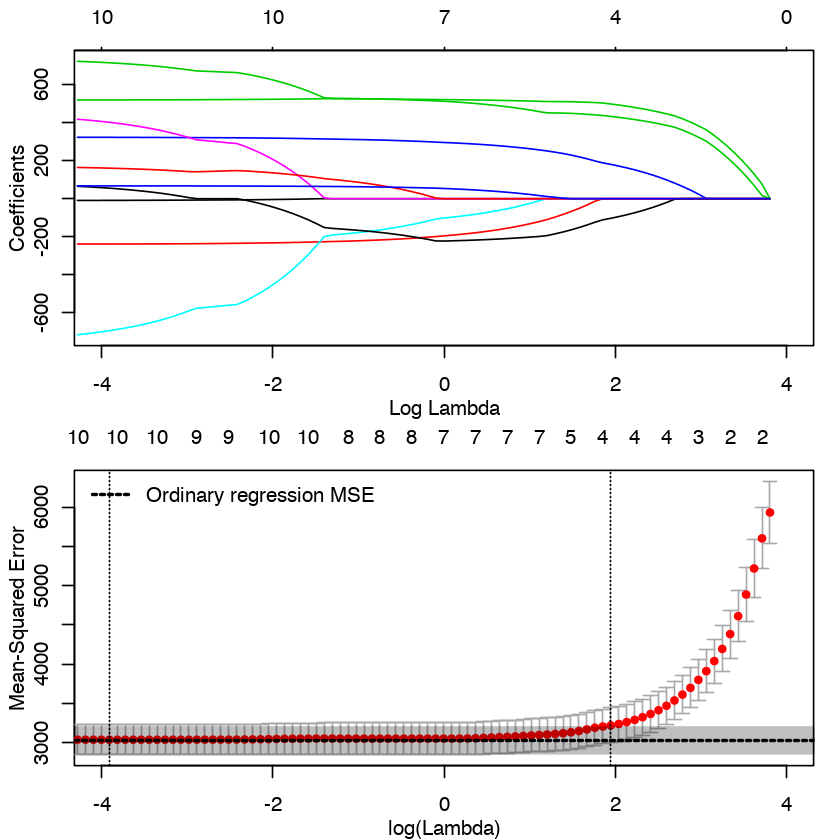

In [14]:
# adjust the plot layout to make a two-panel plot
layout(rbind(1,2))
par(mar=c(3,3,2,1)+.1)

# coefficient path plot
plot(lasso, xvar="lambda", xlim=c(-4,4), mgp=2:0)

# CV error plot
plot(CV, xlim=c(-4,4), mgp=2:0)

# add the baseline performance of the ordinary regression model
with(reg_CV, polygon(x=c(-10,10,10,-10,-10),
                     y=c(cvup[1],cvup[1],cvlo[1],cvlo[1],cvup[1]),
                     border=NA, col=rgb(0,0,0,.25)))
abline(h=reg_CV$cvm[1], lty=2, lwd=2)
legend("topleft", lty=2, lwd=2, legend="Ordinary regression MSE", bty="n")

The top panel shows the *coefficient paths*, that is, it shows the values of all the estimated regression coefficients (slopes) as a function of lambda. You can see that the more regularization is applied, the more the coefficients are pushed toward 0. The numbers along the top of both panels give the number of predictors that still have non-zero regression coefficients for that level of lambda. At the far right side of the plot, the regularization is so strong that all of the coefficients have been pushed down to 0.

The bottom panel shows the estimated test error (estimated via repeated 10-fold cross-validation) as a function of lambda. Note that the y-axis is in units of mean squared error, rather than root mean squared error (RMSE) as we were been using above, but we can simply take the square root of these values to turn them back into RMSEs if we want to. By default the plot includes two vertical dotted lines. The line on the left gives the optimal value of lambda, that is, the value of lambda that led to the lowest estimated test error. The line on the right gives the value of lambda that satisfies the "one standard error rule", which says to pick the simplest model whose estimated test error is still within one standard error of the optimal model. For reference, the gray band and thick, dashed line represent the baseline performance of the ordinary regression model that uses no regularization.

The basic lesson from these plots is that in this case, with these predictors, the Lasso does not offer any real advantage over the ordinary regression model. The optimal value of lambda is technically one in which some regularization is applied and 3 of the predictors are dropped from the model, but the CV error of this model is essentially the same as in the ordinary regression model. In fact, all values of lambda below about log(lambda)=1 or so lead to the same performance as in the regression model, and above that the test error suffers. However, we can also see that if we apply the one standard error rule, we could drop half of the predictors from the model entirely, and the estimated test error for this simpler model would not be appreciably higher than in the optimal (regression) model. 

## Adding nonlinear predictors

Now let's make things a little more interesting. Geometrically speaking, so far we have only attempted to fit a hyperplane to the data. But it's possible that we could do better using a more complicated model that fits a curved, nonlinear surface to the data. One easy way to achieve this is by adding in a bunch of predictors corresponding to all possible products of the original 10 predictors -- essentially, we add the two-way interactions between all the predictors as well as the squared terms for each predictor.

In [15]:
pairs <- t(combn(ncol(X), 2))
interactions <- sapply(seq(choose(ncol(X), 2)), function(i){
  X[,pairs[i,1]]*X[,pairs[i,2]]
})
X2 <- cbind(X, X^2, interactions)

This augmented dataset, `X2`, has 65 predictors instead of just 10:

In [16]:
ncol(X2)

[1] 65

Now let's see how the Lasso and regression models do using this larger, more flexible set of predictors.

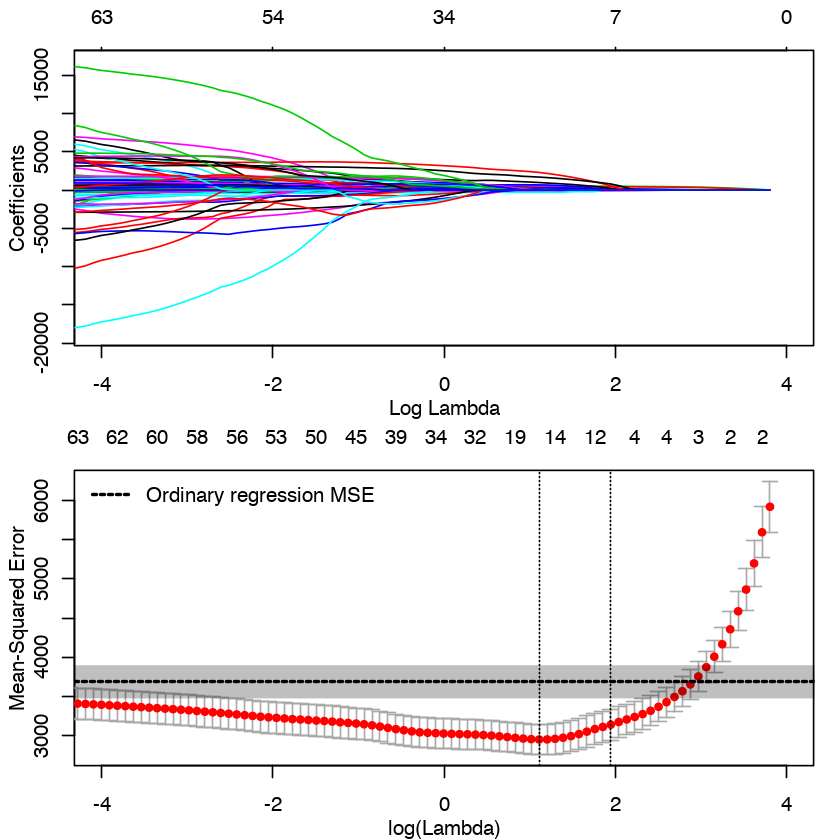

In [17]:
# fit the models
lasso2 <- glmnet(x=X2, y=y)
CV2 <- cv.glmnet(x=X2, y=y)
reg_CV2 <- cv.glmnet(x=X2, y=y, lambda=exp(c(-10,-9)))

# adjust the plot layout to make a two-panel plot
layout(rbind(1,2))
par(mar=c(3,3,2,1)+.1)

# coefficient path plot
plot(lasso2, xvar="lambda", xlim=c(-4,4), mgp=2:0)

# CV error plot
plot(CV2, xlim=c(-4,4), mgp=2:0)

# add the baseline performance of the ordinary regression model
with(reg_CV2, polygon(x=c(-10,10,10,-10,-10),
                      y=c(cvup[1],cvup[1],cvlo[1],cvlo[1],cvup[1]),
                     border=NA, col=rgb(0,0,0,.25)))
abline(h=reg_CV2$cvm[1], lty=2, lwd=2)
legend("topleft", lty=2, lwd=2, legend="Ordinary regression MSE", bty="n")

There are a couple interesting things to notice here.

First, we can see that the Lasso now outperforms the regression model -- that is, there are values of lambda under which the Lasso's CV error is notably better than regression's CV error. Interestingly, the optimal value of lambda implies dropping about three-quarters of the predictors from the model entirely, although we still end up retaining more (about 15) than we had with the previous set of simpler predictors.

The second thing is to notice how the Lasso and regression model respond to the increased flexibility that we gave to them. For the regression model, when we allowed it to use all those nonlinear predictors, it happily did so, and it found a solution that seemed to be even better than with the simple predictors -- recall that the in-sample RMSE of the regression model was about 54 before, but now it's about 53 using the more complex predictor set:

In [18]:
summary(lm(y ~ X2))$sigma

[1] 53.23039

But when we look at the CV error of the regression model, we can see that this increase in accuracy is in fact an illusion, a result of nothing but increased overfitting. When using the augmented predictor set, the regression's CV error actually *increased* from about RMSE=54 to about RMSE=59:

In [19]:
sqrt(reg_CV2$cvm[1])

[1] 60.73967

In other words, the regression model appears naively to have done better using the increased flexibility, but it actually did worse.

The Lasso, on the other hand, was not fazed by the increased flexibility. The Lasso's CV error, recall, was about RMSE=54 using the simple predictor set, and it remains at about RMSE=54 using the augmented predictor set:

In [20]:
with(CV2, sqrt(cvm[lambda == lambda.min]))

[1] 54.34475

So, while the Lasso was not able to take advantage of the increased flexibility to actually make better predictions, it did at least avoid using this flexibility to overfit the data, unlike the regression model.

## Bonus material: Nested cross-validation

So far, our strategy has been to select the model (i.e., the value of lambda) that leads to the best CV error, and then to use that CV error as our estimate of the test error. But if we're simply selecting the value of lambda that minimizes the CV error computed using all the data at hand, then doesn't this open the door to overfitting the data with respect to our selection of lambda? The method of CV we've been using takes into account the fact that the regression coefficients are selected so as to minimize error in the training data, but it ignores the possibility that we may also be selecting *lambda* so as to minimize error in the training data. Because of this, if we do use CV error to select a value of lambda -- rather than just using the CV error to tell us about the test error, without using that CV error to make any model selection decisions -- then this does render the simple CV error an overly optimistic estimate of the true test error we would experience in future data.

It is possible to correct for this optimistic bias using *nested cross-validation*. The basic idea is that we extend the simple CV procedure so that the selection of lambda takes place within each loop or fold of the CV, rather than only taking place after the fact. In simple CV, the same fixed value of lambda is used for each fold. In nested CV, different folds can use different values of lambda.

Concretely, here is what it looks like:

In [21]:
# empty vector to hold results
RMSE <- numeric(10)
# do this stuff for each fold
for(i in 1:10){
  # fit LASSO to the 9 training folds
  mod <- cv.glmnet(x=X2[-indices[[i]],], y=y[-indices[[i]]])
  # get predicted values for test fold using "optimal" lambda from training
  predictions <- mean(y[indices[[i]]]) + X2[indices[[i]],] %*%
    mod$glmnet.fit$beta[,which.min(mod$cvm)]
  # compute and save RMSE
  errors <- y[indices[[i]]] - predictions
  RMSE[i] <- sqrt(mean(errors^2))
}
mean(RMSE)

[1] 54.82751

Note that in this case, the nested CV error is pretty much the same as the simple CV error, which we estimated earlier to be about 54. Basically, if we are only fiddling with a single tuning parameter (lambda) and the sample size is not too small, then the optimistic bias of simple CV tends to be negligible. The cases where nested CV tends to make a big difference are when we are using the CV error to select among many models, each possessing multiple tuning parameters, and the size of the training set is relatively small so that performance can vary drastically from fold to fold. In such cases, the simple CV error can be a badly over-optimistic estimate of the true test error, because it ignores the fact that we searched through many, many possible models before finding the one that minimized the CV error in the training set.